# Assignment 3
### Rameen Usman and Keerthi Srilakshmidaran

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import pathlib

## Import Data

In [ ]:
# Access zip image data file from box
!wget https://utdallas.box.com/shared/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip

--2022-11-27 23:55:33--  https://utdallas.box.com/shared/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip
Resolving utdallas.box.com (utdallas.box.com)... 74.112.186.144
Connecting to utdallas.box.com (utdallas.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip [following]
--2022-11-27 23:55:33--  https://utdallas.box.com/public/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip
Reusing existing connection to utdallas.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://utdallas.app.box.com/public/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip [following]
--2022-11-27 23:55:34--  https://utdallas.app.box.com/public/static/jtrkpsolmtznosybknchfsh4ftaev2r5.zip
Resolving utdallas.app.box.com (utdallas.app.box.com)... 74.112.186.144
Connecting to utdallas.app.box.com (utdallas.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting 

In [ ]:
# unzip file in colab
import zipfile
with zipfile.ZipFile('/content/jtrkpsolmtznosybknchfsh4ftaev2r5.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/data')

#/content/jtrkpsolmtznosybknchfsh4ftaev2r5.zip

In [ ]:
data_dir = pathlib.Path('/content/data/content/jpegs_train/PetImages')

## Data Preprocessing & Model Building

In [ ]:
batch_size = 32
img_height = 160
img_width = 160

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18610 files belonging to 2 classes.
Using 14888 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18610 files belonging to 2 classes.
Using 3722 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Dog']


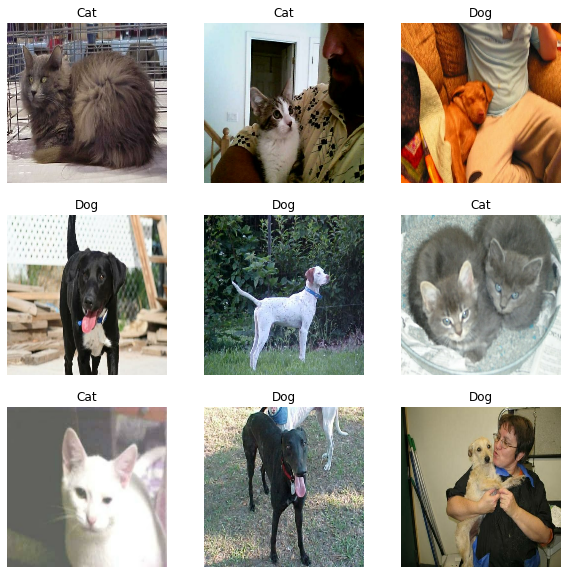

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 94
Number of test batches: 23


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

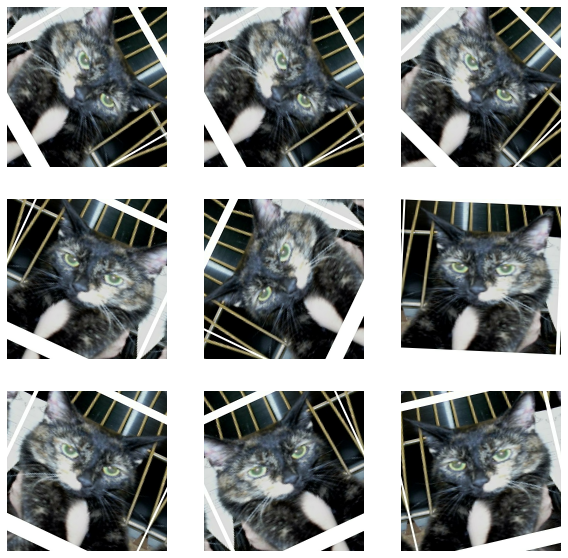

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[8]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
##### HERE ######
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               classifier_activation = "sigmoid",
                                               alpha = 1
                                               )

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
print(IMG_SHAPE)

(160, 160, 3)


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
len(base_model.layers)

154

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
from keras.layers import Dense
from keras.layers import Conv2D

# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = Dense(units = 3)(x)
# x = base_model(x, training=False)
# x = Dense(units = 1280)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = Dense(units=1280)(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

# # LAYER = 11
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = Dense(units=3)(x)
# x = base_model(x, training=False)
# x = Dense(units=1280)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

# LAYER = 9
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = Dense(units=3)(x)
# x = base_model(x, training=False)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

# LAYER = 12
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = Dense(units=3)(x)
# x = base_model(x, training=False)
# x = Dense(units=3)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = global_average_layer(x)
# x = Dense(units=1280)(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

# LAYER = 10
# inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
# x = Dense(units=3)(x)
# x = base_model(x, training=False)
# x = Dense(units=1280)(x)
# x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# outputs = prediction_layer(x)
# model = tf.keras.Model(inputs, outputs)

LAYER = 8
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [ ]:
len(model.layers)

8

## Model Testing & Parameter Tuning

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
initial_epochs = 5
loss0, accuracy0 = model.evaluate(val_ds)

94/94 [==============================] - 7s 46ms/step - loss: 0.7483 - accuracy: 0.5529


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/5
466/466 [==============================] - 40s 80ms/step - loss: 0.3824 - accuracy: 0.8051 - val_loss: 0.1518 - val_accuracy: 0.9498
Epoch 2/5
466/466 [==============================] - 35s 75ms/step - loss: 0.1936 - accuracy: 0.9181 - val_loss: 0.0986 - val_accuracy: 0.9702
Epoch 3/5
466/466 [==============================] - 37s 78ms/step - loss: 0.1646 - accuracy: 0.9310 - val_loss: 0.0784 - val_accuracy: 0.9756
Epoch 4/5
466/466 [==============================] - 37s 80ms/step - loss: 0.1467 - accuracy: 0.9378 - val_loss: 0.0701 - val_accuracy: 0.9779
Epoch 5/5
466/466 [==============================] - 37s 78ms/step - loss: 0.1403 - accuracy: 0.9415 - val_loss: 0.0639 - val_accuracy: 0.9792


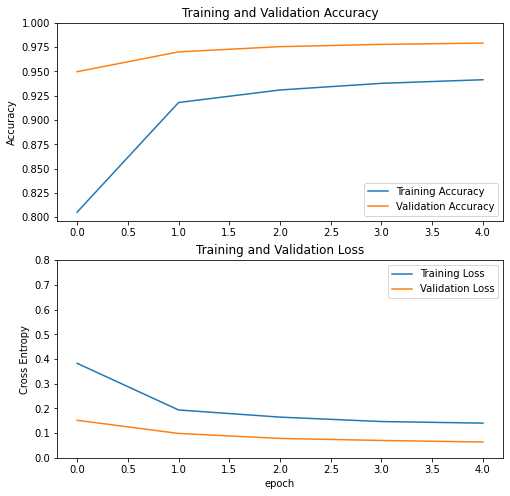

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

23/23 [==============================] - 1s 47ms/step - loss: 0.0502 - accuracy: 0.9823
Test accuracy : 0.9823369383811951


Predictions:
 [1 0 1 1 1 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 1 1 0]
Labels:
 [1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0]


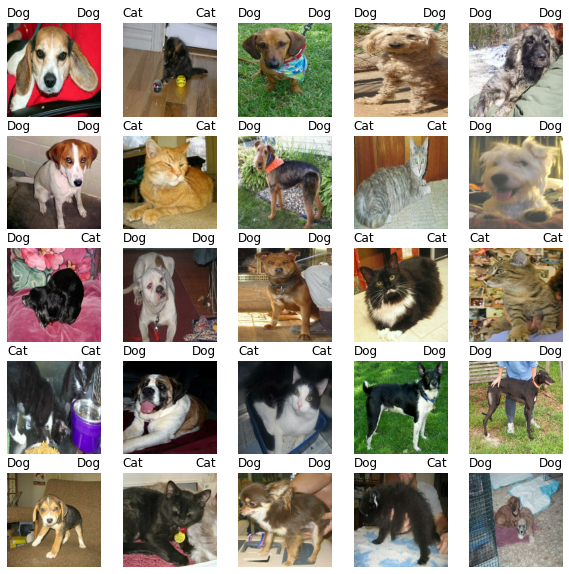

In [ ]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[label_batch[i]], loc = 'left')
  plt.title(class_names[predictions[i]], loc = 'right')
  plt.axis("off")